In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os, scipy
import pickle
import copy

# We import the model, stimuli, and the optimal control package
from neurolib.models.wc import WCModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.control.optimal_control import oc_wc, cost_functions

import matplotlib as mpl
label_size= 20
mpl.rcParams['xtick.labelsize'] = label_size
mpl.rcParams['ytick.labelsize'] = label_size
mpl.rcParams['font.size'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['figure.titlesize'] = label_size
mpl.rcParams['lines.linewidth'] = 1

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

while "Promotion/neurolib" in os.getcwd():
    os.chdir('..')

pickledir = os.path.join(os.getcwd(), "neurolib_aln_osc_datastorage/optimal_control/WP2/2n")
dir = os.path.join(pickledir, "images_2n_wc_static_short")

print(dir)

def get_period(timeseries, dt):
    peaks = scipy.signal.find_peaks(timeseries, prominence=0.001)[0]
    periods = []
    if len(peaks) < 3:
        return 0.
    for i in range(2, len(peaks)-1):
        periods.append( (peaks[i] - peaks[i-1]) * dt)

    print(periods)
    return np.mean(periods)

def plotspectrum(data, fmax=1., filename=None):

    for d in data:
        ps = np.abs(np.fft.fft(d))
        ps_plot = ps[:int(len(ps)/2)]
        ps_plot[0] = 0.

        fr = np.linspace(0,1./(2.*dt),len(ps_plot))

        plt.plot(fr, ps_plot)

    plt.xlim(-0.01,fmax)
    plt.ylim(0,1.1*np.amax(ps_plot))
    plt.tight_layout()

    if filename is not None:
        plt.savefig(os.path.join(dir, filename))
    
    plt.show()

    maxfreqind = np.where(ps_plot == max(ps_plot[1:]))
    print("freq of max = ", fr[maxfreqind])
    print("period of max = ", 1./fr[maxfreqind])

    return (1./fr[maxfreqind])[0]

/home/lena/Promotion/neurolib_aln_osc_datastorage/optimal_control/WP2/2n/images_2n_wc_static_short


In [2]:
y0lim = [0, 0.6]

def plot_control1(c, s, dur, dt, filename=None, title=None):
    fig, ax = plt.subplots(2,2, figsize=(12,5), sharex="col", sharey="row")
    time_array = np.linspace(0,dur,s.shape[2])

    cmax = np.amax(np.abs(c))
    y1lim = [-cmax* 1.1, cmax* 1.1]

    for n in range(N):
        ax[0, n].plot(time_array, s[n,0,:], color="red", label="E")
        ax[0, n].plot(time_array, s[n,1,:], color="blue", label="I")
        ax[1, n].plot(time_array, c[n,0,:], color="red", label="E")
        ax[1, n].plot(time_array, c[n,1,:], color="blue", label="I")


    ax[0,0].legend(loc="lower right")
    ax[1,0].legend(loc="lower right")

    ax[0,0].set_xlim(0, dur)
    ax[0,1].set_xlim(0, dur)

    ax[0,0].set_ylim(y0lim)
    ax[1,0].set_ylim(y1lim)

    ax[1,0].set_xlabel("Time")
    ax[1,1].set_xlabel("Time")
    ax[0,0].set_ylabel("Activity")
    ax[1,0].set_ylabel("Control")

    ax[0,0].set_title("n=0")
    ax[0,1].set_title("n=1")

    plt.subplots_adjust(
                    wspace=0.15,
                    hspace=0.1)
    
    fig.align_ylabels([ax[:,0]])
    
    if title is not None:
        fig.suptitle(title)

    if filename is not None:
        plt.savefig(filename, bbox_inches='tight', dpi=200)

    plt.show()
    return

In [3]:
p_names = ["D-exp"]
coords = [[0., 2.]]

coupling = 1.8
cmat = np.array( [[0., 1.], [1., 0.]] )
N = cmat.shape[0]

D-exp


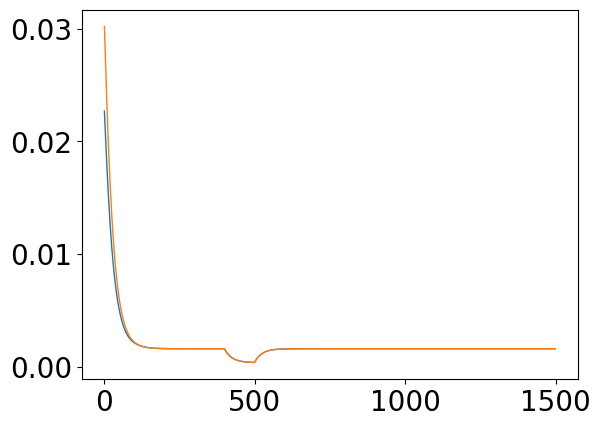

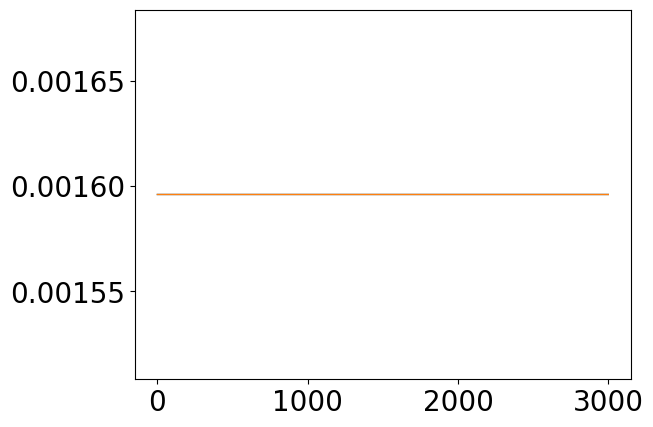

In [6]:
if True:
    data = dict()

    for i in range(len(p_names)):
        p = p_names[i]
        data[p] = dict()
        data[p]["coordinates"] = coords[i]
        data[p]["target_period"] = 20.
        data[p]["delay"] = 9.5
        data[p]["control"] = [None, None]
        data[p]["state"] = [None, None]
        data[p]["init_state"] = None
        data[p]["weight"] = [5. * 1e-5, 5. * 1e-4]
        data[p]["dur/per"] = [340., 10]


duration = 1e5
dt = 0.1

test_input_plus = ZeroInput().generate_input(duration=duration+dt, dt=dt)
test_input_plus[:,400:500] = 1.

test_input_minus = ZeroInput().generate_input(duration=duration+dt, dt=dt)
test_input_minus[:,400:500] = -1.

for pi in range(len(p_names)):

    print(p_names[pi])

    model = WCModel(Cmat=cmat, Dmat=data[p_names[pi]]["delay"]*20.*cmat)

    model.params['duration'] = duration
    model.params.exc_ext_baseline = data[p_names[pi]]["coordinates"][0]
    model.params.inh_ext_baseline = data[p_names[pi]]["coordinates"][1]
    model.params["exc_ext"] = test_input_minus

    model.params.K_gl = coupling
    model.run()
    nmaxdelay = model.getMaxDelay()

    einit = np.zeros((N, nmaxdelay+1))
    iinit = np.zeros((N, nmaxdelay+1))

    for n in range(N):
        einit[n,:] = model.exc[n,-nmaxdelay-1:]
        iinit[n,:] = model.inh[n,-nmaxdelay-1:]

    data[p_names[pi]]["init_state"] = [einit, iinit]

    plt.plot(model.exc[0,0:1500])
    plt.plot(model.exc[1,0:1500])
    plt.show()
    plt.plot(model.exc[0,-3000:])
    plt.plot(model.exc[1,-3000:])
    plt.show()

In [7]:
controlmat = np.ones((N,2))

costmat = np.zeros((N, 2))
costmat[:,0] = 1.

it = 50
maxstr = 5

pr = np.arange(0,1001,20)
testd = 1000.

zero_input0 = ZeroInput().generate_input(duration=duration+model.params.dt, dt=model.params.dt)
zero_input = np.vstack( ([zero_input0]*2) )[np.newaxis,:,:]
zero_control = np.vstack( ([zero_input]*N))

In [8]:
def optimize_model(model, exprange):
    for l in range(2):
        for k in exprange:
            model.zero_step_encountered = False
            model.step = 10**(k)
            model.optimize(it)
        model.control_matrix = controlmat
    model.zero_step_encountered = False

    return

In [9]:
from numba.typed import Dict
from numba.core import types

weights = Dict.empty(
        key_type=types.unicode_type,
        value_type=types.float64,
    )

weights["w_2"] = 1.0
weights["w_1"] = 0.0
weights["w_1T"] = 0.0
weights["w_1D"] = 0.0

period_range = np.arange(11., 16., 0.3)
period_range = np.arange(11., 16., 0.3)
pr_ = period_range.copy()

period_range = np.zeros(( len(pr_) + 5 ))
for i in range(len(pr_)):
    period_range[i] = pr_[i]

period_range[-5] = 18
period_range[-4] = 20
period_range[-3] = 23
period_range[-2] = 26
period_range[-1] = 30

print(len(period_range))

c0 = [None] * len(period_range)
s0 = [None] * len(period_range)

c1 = [None] * len(period_range)
s1 = [None] * len(period_range)

c2 = [None] * len(period_range)
s2 = [None] * len(period_range)

pi = 0

22


Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.03542072977287145
Cost in iteration 20: -0.03947714547827857
Cost in iteration 40: -0.03959595809257209
Final cost : -0.03959892927479286
Compute control for a deterministic system
Cost in iteration 0: -0.03959892927479286
Cost in iteration 20: -0.03959985313770783
Converged in iteration 25 with cost -0.03959985313770803
Final cost : -0.03959985313770803
Compute control for a deterministic system
Cost in iteration 0: -0.03959985313770803
Converged in iteration 2 with cost -0.03959985313770803
Final cost : -0.03959985313770803
Compute control for a deterministic system
Cost in iteration 0: -0.03959985313770803
Converged in iteration 2 with cost -0.03959985313770803
Final cost : -0.03959985313770803
Compute control for a deterministic system
Cost in iteration 0: -0.03959985313770803
Converged in iteration 2 with cost -0.03959985313770803
Final cost : -0.03959985313770803
----

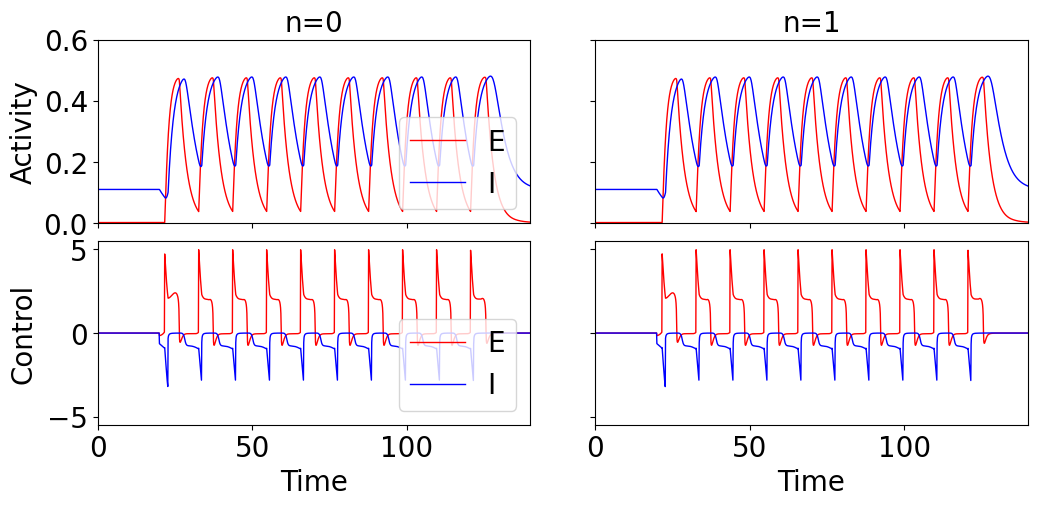

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.03646346084128525
Cost in iteration 20: -0.04046863016754417
Cost in iteration 40: -0.04057368675624176
Final cost : -0.04058144868516898
Compute control for a deterministic system
Cost in iteration 0: -0.04058144868516898
Cost in iteration 20: -0.04058646132932343
Cost in iteration 40: -0.04058654160363745
Converged in iteration 40 with cost -0.04058654160363745
Final cost : -0.04058654160363745
Compute control for a deterministic system
Cost in iteration 0: -0.04058654160363745
Converged in iteration 2 with cost -0.04058654160363745
Final cost : -0.04058654160363745
Compute control for a deterministic system
Cost in iteration 0: -0.04058654160363745
Converged in iteration 2 with cost -0.04058654160363745
Final cost : -0.04058654160363745
Compute control for a deterministic system
Cost in iteration 0: -0.04058654160363745
Converged in iteration 2 with cost -0.0405865416036

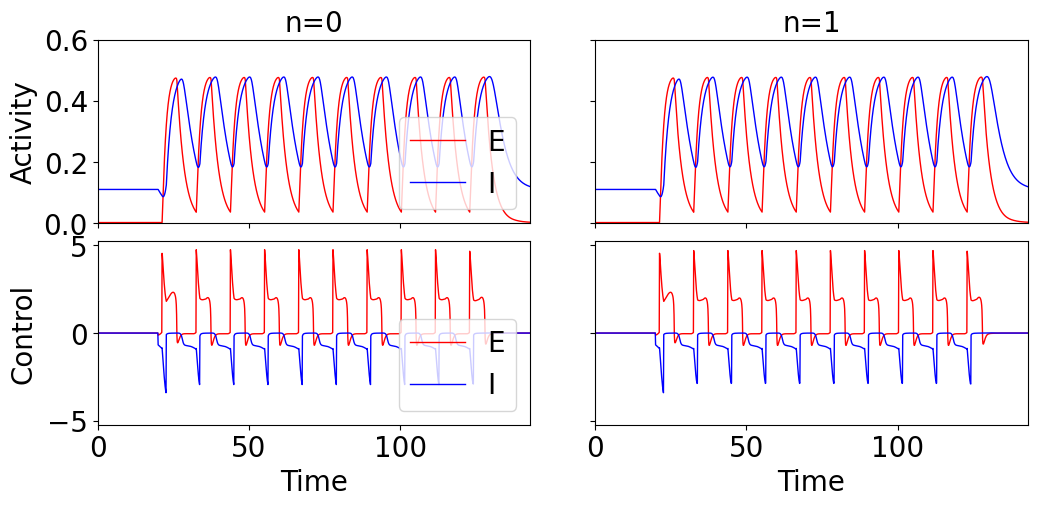

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.03745791322525224
Cost in iteration 20: -0.04159998817752182
Cost in iteration 40: -0.041718550302488236
Final cost : -0.0417206139118243
Compute control for a deterministic system
Cost in iteration 0: -0.0417206139118243
Cost in iteration 20: -0.04172127246580063
Converged in iteration 21 with cost -0.04172127246580063
Final cost : -0.04172127246580063
Compute control for a deterministic system
Cost in iteration 0: -0.04172127246580063
Converged in iteration 2 with cost -0.04172127246580063
Final cost : -0.04172127246580063
Compute control for a deterministic system
Cost in iteration 0: -0.04172127246580063
Converged in iteration 2 with cost -0.04172127246580063
Final cost : -0.04172127246580063
Compute control for a deterministic system
Cost in iteration 0: -0.04172127246580063
Converged in iteration 2 with cost -0.04172127246580063
Final cost : -0.04172127246580063
-----

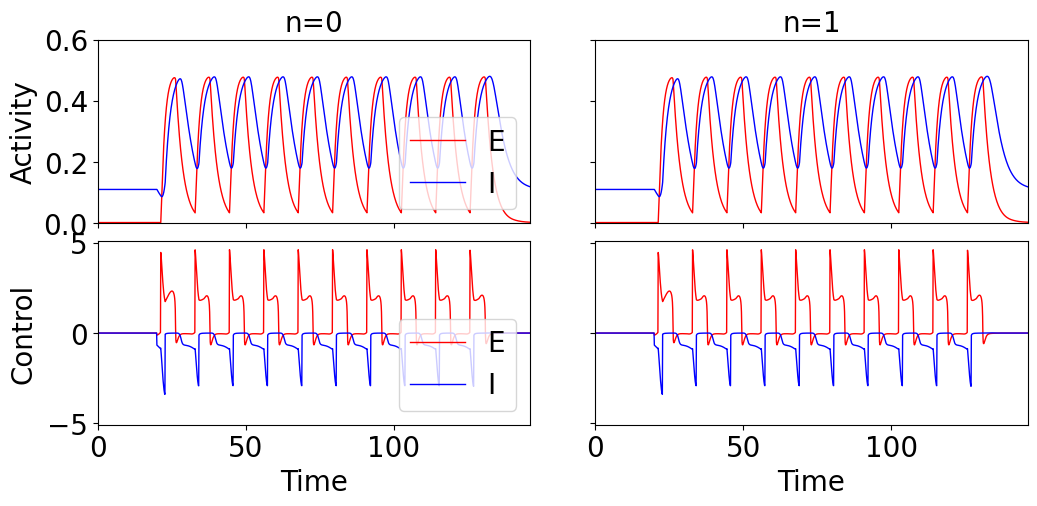

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.038752039734399855
Cost in iteration 20: -0.042990627729673825
Cost in iteration 40: -0.04307719424246734
Final cost : -0.04309532940578947
Compute control for a deterministic system
Cost in iteration 0: -0.04309532940578947
Cost in iteration 20: -0.043115908716665714
Cost in iteration 40: -0.043116199993160624
Final cost : -0.043116200856016584
Compute control for a deterministic system
Cost in iteration 0: -0.043116200856016584
Converged in iteration 9 with cost -0.04311620085601674
Final cost : -0.04311620085601674
Compute control for a deterministic system
Cost in iteration 0: -0.04311620085601674
Converged in iteration 2 with cost -0.04311620085601674
Final cost : -0.04311620085601674
Compute control for a deterministic system
Cost in iteration 0: -0.04311620085601674
Converged in iteration 2 with cost -0.04311620085601674
Final cost : -0.04311620085601674
------------

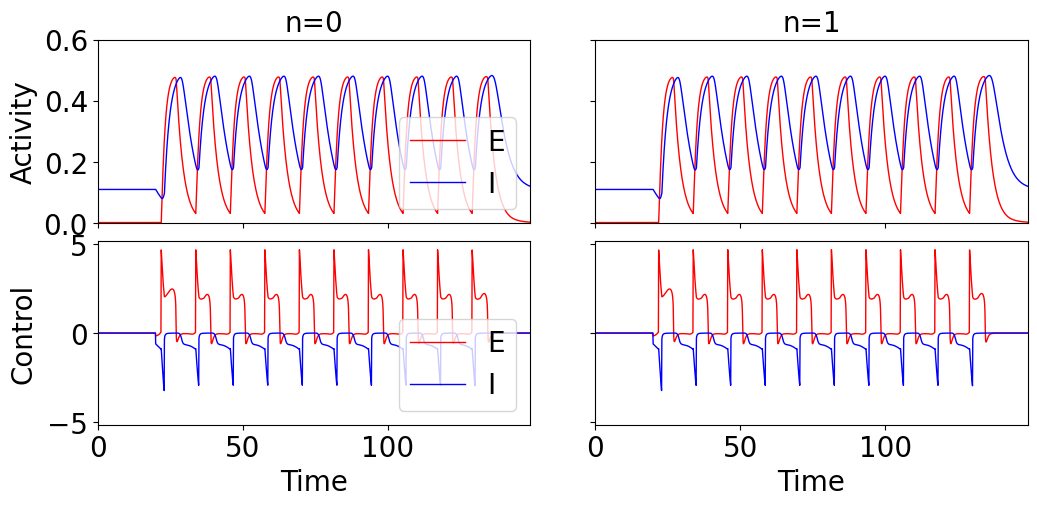

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.03936341110478988
Cost in iteration 20: -0.043726604745149236
Cost in iteration 40: -0.04380901737063759
Final cost : -0.0438145136678323
Compute control for a deterministic system
Cost in iteration 0: -0.0438145136678323
Cost in iteration 20: -0.04383903475225875
Cost in iteration 40: -0.04384086331630675
Final cost : -0.04384091013418894
Compute control for a deterministic system
Cost in iteration 0: -0.04384091013418894
Converged in iteration 18 with cost -0.043840921695233466
Final cost : -0.043840921695233466
Compute control for a deterministic system
Cost in iteration 0: -0.043840921695233466
Converged in iteration 1 with cost -0.043840921695233466
Final cost : -0.043840921695233466
Compute control for a deterministic system
Cost in iteration 0: -0.043840921695233466
Converged in iteration 1 with cost -0.043840921695233466
Final cost : -0.043840921695233466
----------

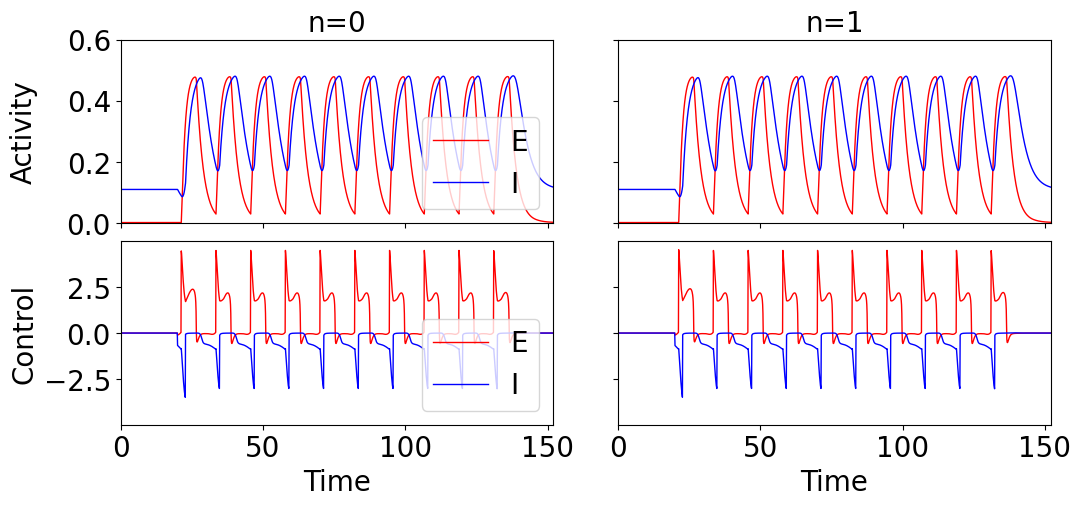

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.04025723626371913
Cost in iteration 20: -0.044710124769197654
Cost in iteration 40: -0.04478927783413208
Final cost : -0.04479459270118494
Compute control for a deterministic system
Cost in iteration 0: -0.04479459270118494
Cost in iteration 20: -0.044796498361099155
Cost in iteration 40: -0.04479658302806289
Final cost : -0.04479658303356404
Compute control for a deterministic system
Cost in iteration 0: -0.04479658303356404
Cost in iteration 20: -0.04479658313037166
Converged in iteration 30 with cost -0.044796583130371756
Final cost : -0.044796583130371756
Compute control for a deterministic system
Cost in iteration 0: -0.044796583130371756
Converged in iteration 2 with cost -0.044796583130371756
Final cost : -0.044796583130371756
Compute control for a deterministic system
Cost in iteration 0: -0.044796583130371756
Converged in iteration 2 with cost -0.044796583130371756

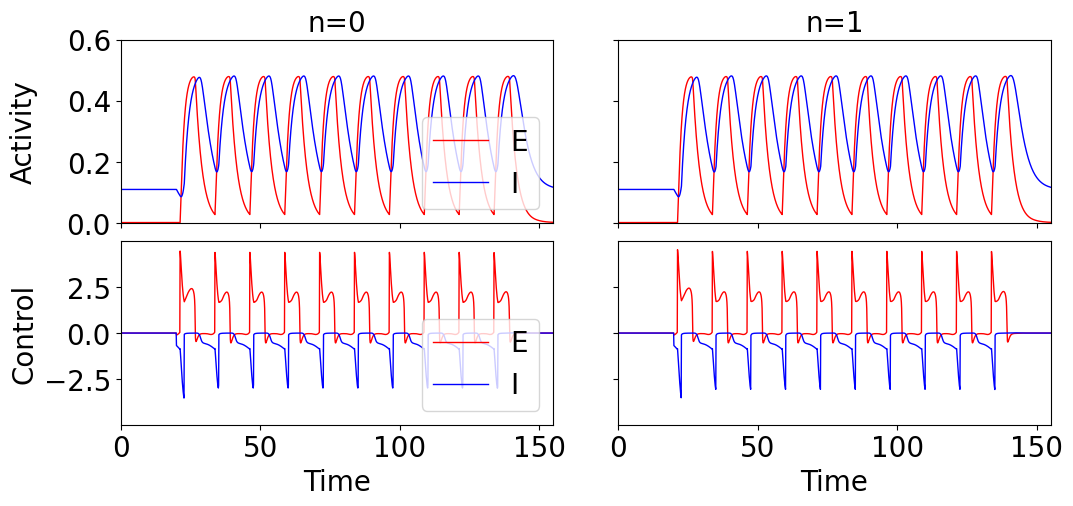

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.04121682107893729
Cost in iteration 20: -0.04567652675387791
Cost in iteration 40: -0.04577666491769041
Final cost : -0.04578336807969199
Compute control for a deterministic system
Cost in iteration 0: -0.04578336807969199
Cost in iteration 20: -0.04578699246854061
Converged in iteration 26 with cost -0.04578699571389104
Final cost : -0.04578699571389104
Compute control for a deterministic system
Cost in iteration 0: -0.04578699571389104
Converged in iteration 2 with cost -0.04578699571389104
Final cost : -0.04578699571389104
Compute control for a deterministic system
Cost in iteration 0: -0.04578699571389104
Converged in iteration 2 with cost -0.04578699571389104
Final cost : -0.04578699571389104
Compute control for a deterministic system
Cost in iteration 0: -0.04578699571389104
Converged in iteration 2 with cost -0.04578699571389104
Final cost : -0.04578699571389104
----

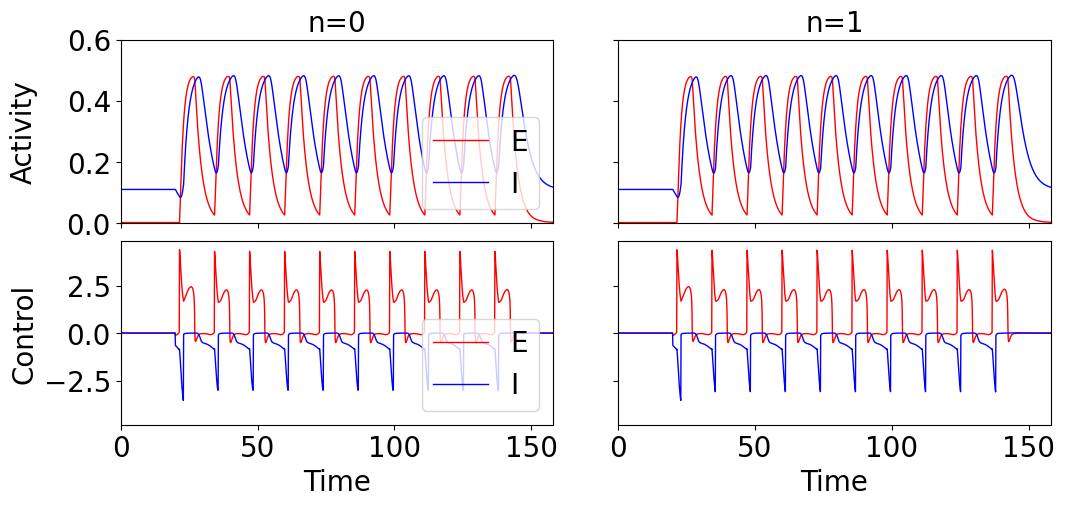

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.04161382518312053
Cost in iteration 20: -0.04638793430502884
Cost in iteration 40: -0.04655421343332544
Final cost : -0.0465587665013579
Compute control for a deterministic system
Cost in iteration 0: -0.0465587665013579
Cost in iteration 20: -0.04656229632678545
Cost in iteration 40: -0.046562576740296124
Final cost : -0.046562607338853194
Compute control for a deterministic system
Cost in iteration 0: -0.046562607338853194
Converged in iteration 4 with cost -0.04656261084715936
Final cost : -0.04656261084715936
Compute control for a deterministic system
Cost in iteration 0: -0.04656261084715936
Converged in iteration 2 with cost -0.04656261084715936
Final cost : -0.04656261084715936
Compute control for a deterministic system
Cost in iteration 0: -0.04656261084715936
Converged in iteration 1 with cost -0.04656261084715936
Final cost : -0.04656261084715936
-----------------

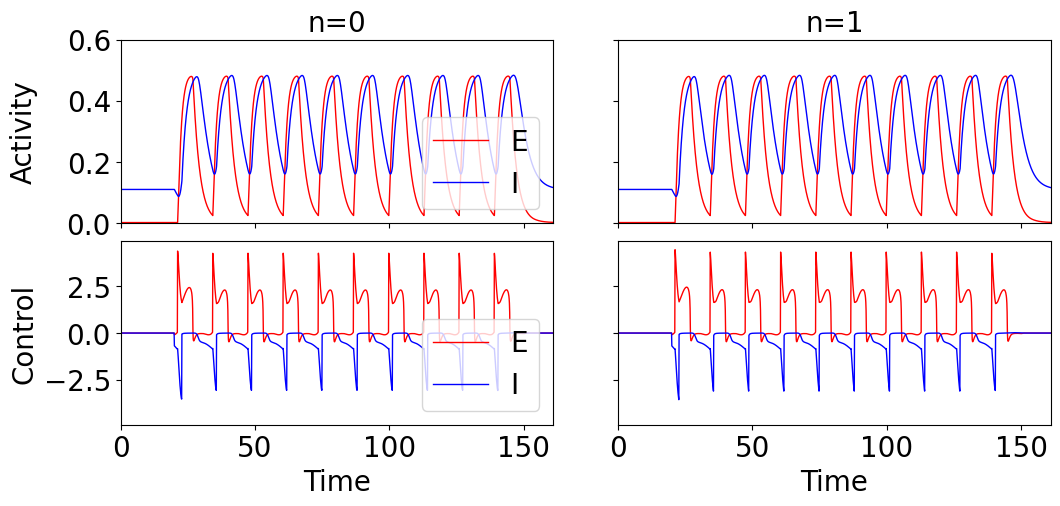

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.04249865867336092
Cost in iteration 20: -0.04719292318402812
Cost in iteration 40: -0.04738010743535234
Final cost : -0.04739250978001401
Compute control for a deterministic system
Cost in iteration 0: -0.04739250978001401
Converged in iteration 18 with cost -0.04739341467645822
Final cost : -0.04739341467645822
Compute control for a deterministic system
Cost in iteration 0: -0.04739341467645822
Converged in iteration 2 with cost -0.04739341467645822
Final cost : -0.04739341467645822
Compute control for a deterministic system
Cost in iteration 0: -0.04739341467645822
Converged in iteration 2 with cost -0.04739341467645822
Final cost : -0.04739341467645822
Compute control for a deterministic system
Cost in iteration 0: -0.04739341467645822
Converged in iteration 2 with cost -0.04739341467645822
Final cost : -0.04739341467645822
------------------------------ period, energy i

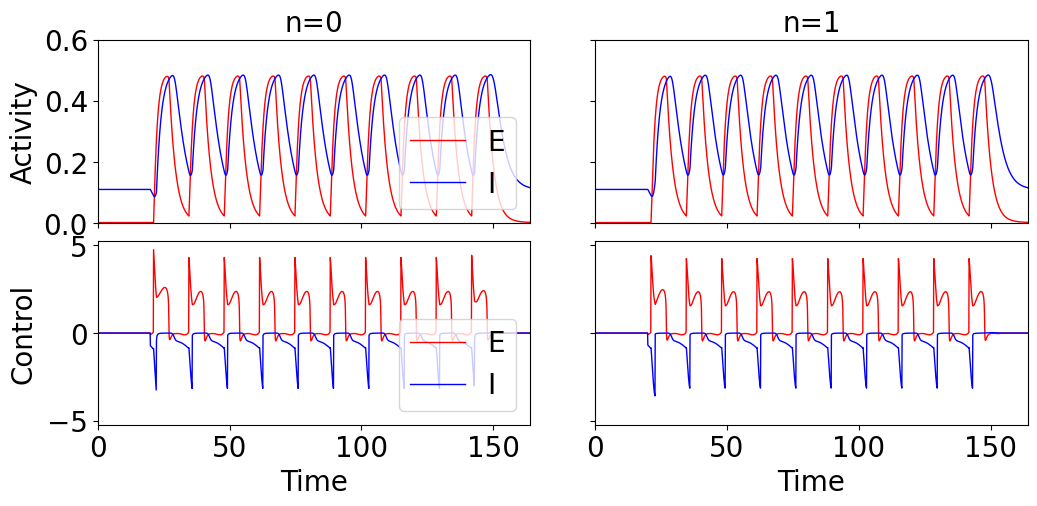

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.043082927701767186
Cost in iteration 20: -0.04805220846289364
Cost in iteration 40: -0.04815707063975814
Final cost : -0.0481656365344449
Compute control for a deterministic system
Cost in iteration 0: -0.0481656365344449
Cost in iteration 20: -0.04816954820333299
Cost in iteration 40: -0.048169633735809625
Converged in iteration 44 with cost -0.048169633735809625
Final cost : -0.048169633735809625
Compute control for a deterministic system
Cost in iteration 0: -0.048169633735809625
Converged in iteration 1 with cost -0.048169633735809625
Final cost : -0.048169633735809625
Compute control for a deterministic system
Cost in iteration 0: -0.048169633735809625
Converged in iteration 1 with cost -0.048169633735809625
Final cost : -0.048169633735809625
Compute control for a deterministic system
Cost in iteration 0: -0.048169633735809625
Converged in iteration 1 with cost -0.0481

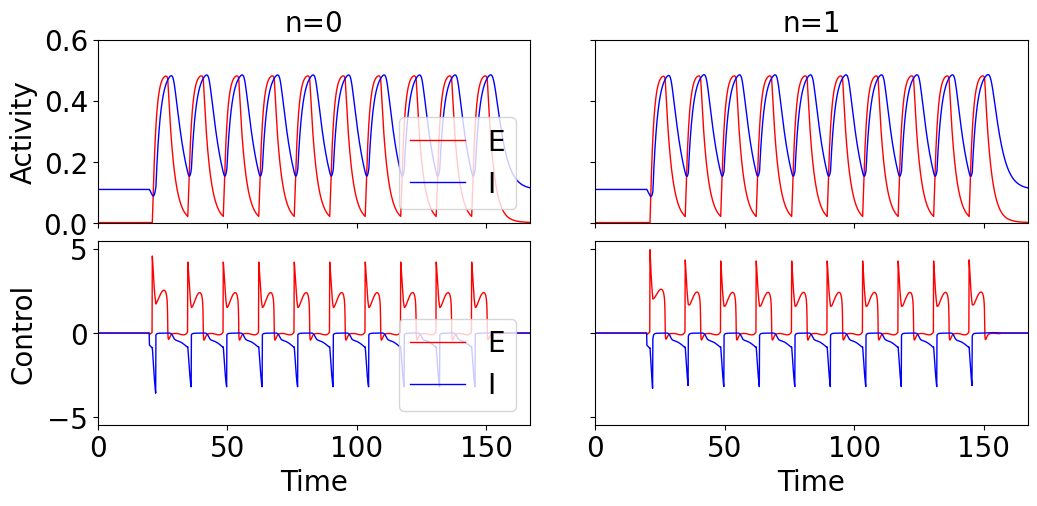

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.04371104864690267
Cost in iteration 20: -0.048661871077501015
Cost in iteration 40: -0.048874596144500626
Final cost : -0.04888387962616007
Compute control for a deterministic system
Cost in iteration 0: -0.04888387962616007
Cost in iteration 20: -0.048886937705772474
Cost in iteration 40: -0.04888716933569556
Final cost : -0.04888720584122866
Compute control for a deterministic system
Cost in iteration 0: -0.04888720584122866
Converged in iteration 15 with cost -0.04888723158627905
Final cost : -0.04888723158627905
Compute control for a deterministic system
Cost in iteration 0: -0.04888723158627905
Converged in iteration 2 with cost -0.04888723158627905
Final cost : -0.04888723158627905
Compute control for a deterministic system
Cost in iteration 0: -0.04888723158627905
Converged in iteration 2 with cost -0.04888723158627905
Final cost : -0.04888723158627905
--------------

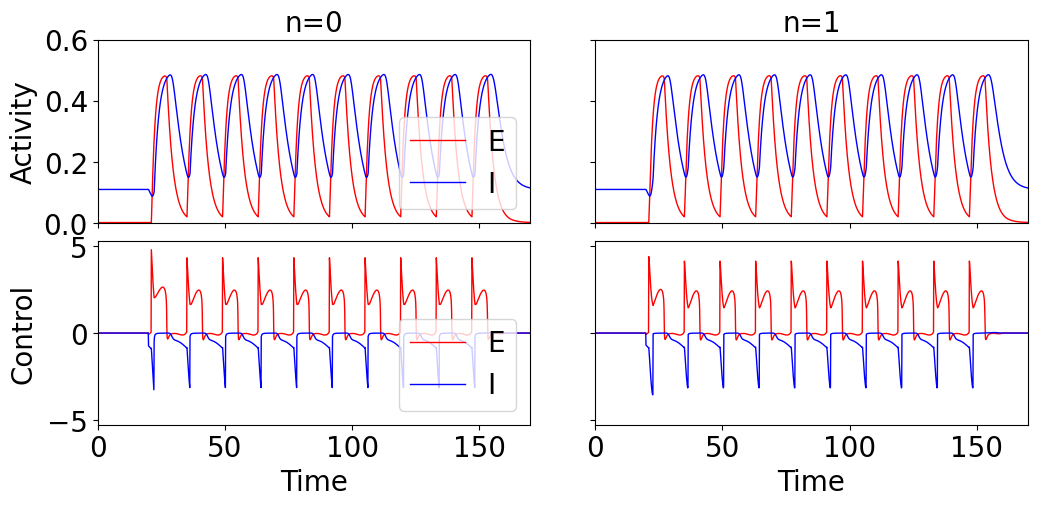

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.04433611125699699
Cost in iteration 20: -0.04951064624080868
Cost in iteration 40: -0.04962181316174326
Final cost : -0.04962824564426388
Compute control for a deterministic system
Cost in iteration 0: -0.04962824564426388
Cost in iteration 20: -0.04963077524546669
Cost in iteration 40: -0.0496309548663558
Final cost : -0.04963097397955295
Compute control for a deterministic system
Cost in iteration 0: -0.04963097397955295
Cost in iteration 20: -0.04963098712275683
Converged in iteration 21 with cost -0.04963098712275683
Final cost : -0.04963098712275683
Compute control for a deterministic system
Cost in iteration 0: -0.04963098712275683
Converged in iteration 2 with cost -0.04963098712275683
Final cost : -0.04963098712275683
Compute control for a deterministic system
Cost in iteration 0: -0.04963098712275683
Converged in iteration 2 with cost -0.04963098712275683
Final cos

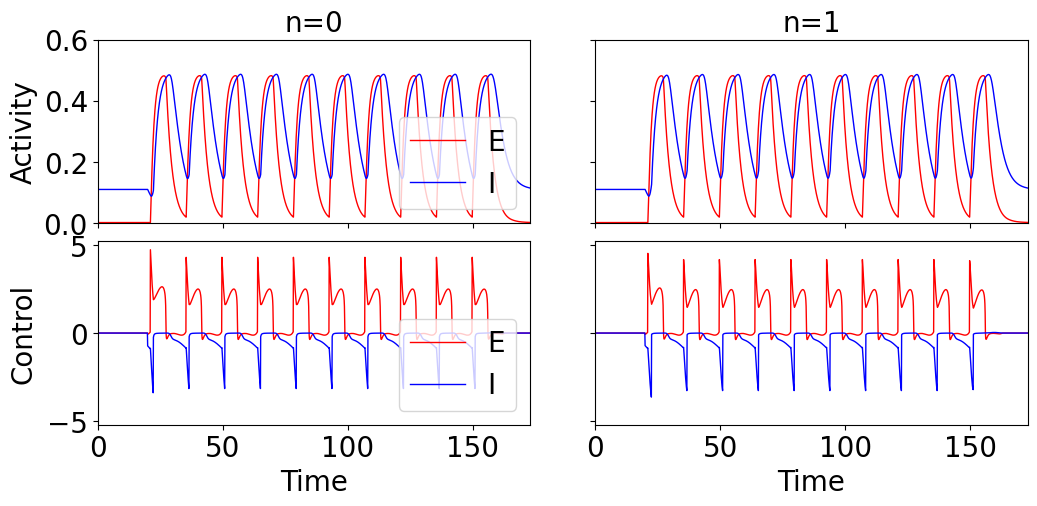

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.0448096100042384
Cost in iteration 20: -0.05000371762382233
Cost in iteration 40: -0.05023957228567267
Final cost : -0.05024512109776667
Compute control for a deterministic system
Cost in iteration 0: -0.05024512109776667
Cost in iteration 20: -0.05027852897970904
Cost in iteration 40: -0.0502809044629989
Final cost : -0.05028105005823312
Compute control for a deterministic system
Cost in iteration 0: -0.05028105005823312
Cost in iteration 20: -0.05028115195055374
Cost in iteration 40: -0.050281162146766124
Converged in iteration 41 with cost -0.050281162146766124
Final cost : -0.050281162146766124
Compute control for a deterministic system
Cost in iteration 0: -0.050281162146766124
Converged in iteration 2 with cost -0.050281162146766124
Final cost : -0.050281162146766124
Compute control for a deterministic system
Cost in iteration 0: -0.050281162146766124
Converged in ite

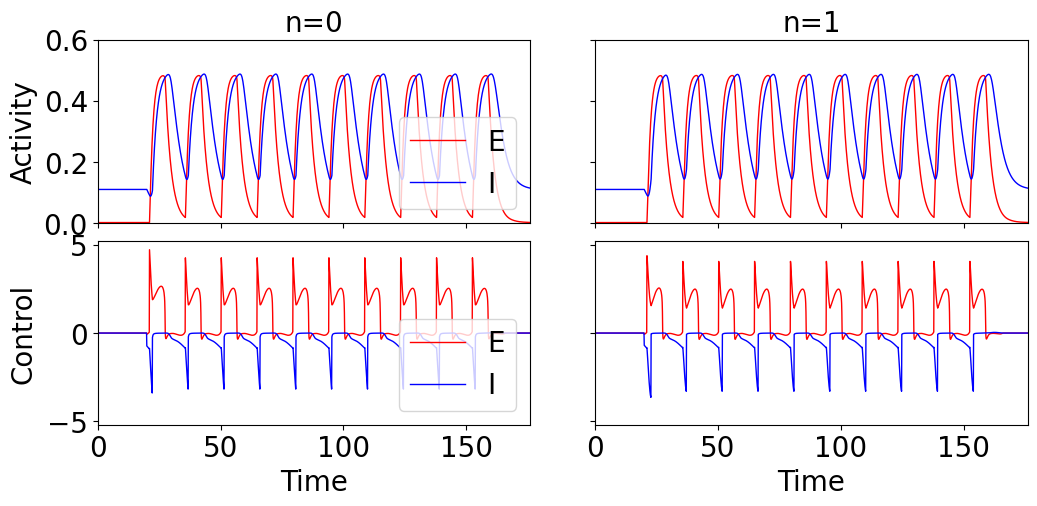

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.04524721050787399
Cost in iteration 20: -0.05059328099341942
Cost in iteration 40: -0.05086817681013948
Final cost : -0.050873561282257694
Compute control for a deterministic system
Cost in iteration 0: -0.050873561282257694
Cost in iteration 20: -0.05087687233024143
Cost in iteration 40: -0.050877113520558126
Final cost : -0.050877162968721704
Compute control for a deterministic system
Cost in iteration 0: -0.050877162968721704
Cost in iteration 20: -0.050907346523962685
Cost in iteration 40: -0.050907405457964364
Converged in iteration 45 with cost -0.05090740545796438
Final cost : -0.05090740545796438
Compute control for a deterministic system
Cost in iteration 0: -0.05090740545796438
Converged in iteration 2 with cost -0.05090740545796438
Final cost : -0.05090740545796438
Compute control for a deterministic system
Cost in iteration 0: -0.05090740545796438
Converged in i

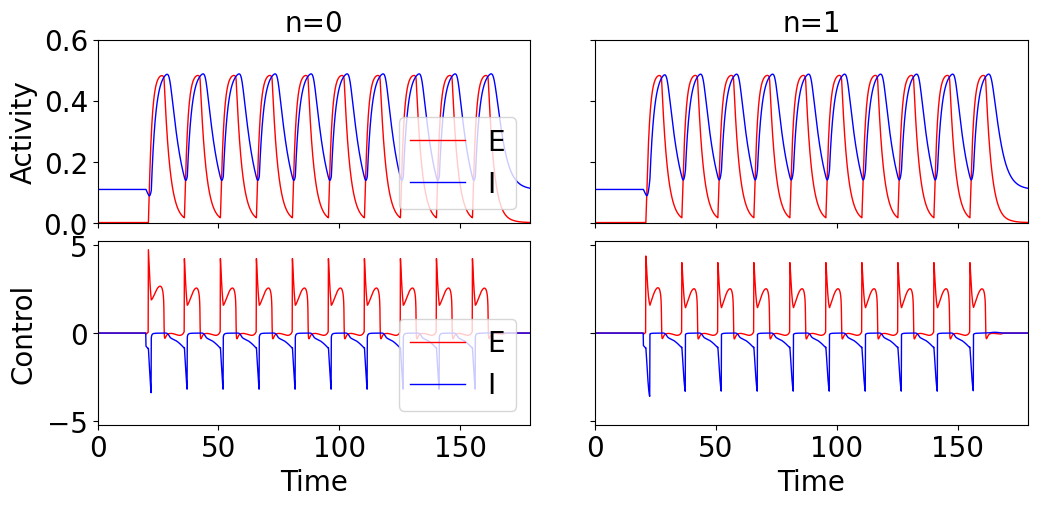

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.04537235300643985
Cost in iteration 20: -0.05105425846056921
Cost in iteration 40: -0.051434327955311526
Final cost : -0.05145835636189252
Compute control for a deterministic system
Cost in iteration 0: -0.05145835636189252
Cost in iteration 20: -0.05149618984090179
Cost in iteration 40: -0.0515034112666364
Final cost : -0.051504681137883
Compute control for a deterministic system
Cost in iteration 0: -0.051504681137883
Cost in iteration 20: -0.05150495959539513
Cost in iteration 40: -0.05150498216621409
Converged in iteration 46 with cost -0.05150498216621412
Final cost : -0.05150498216621412
Compute control for a deterministic system
Cost in iteration 0: -0.05150498216621412
Converged in iteration 2 with cost -0.05150498216621412
Final cost : -0.05150498216621412
Compute control for a deterministic system
Cost in iteration 0: -0.05150498216621412
Converged in iteration 2 

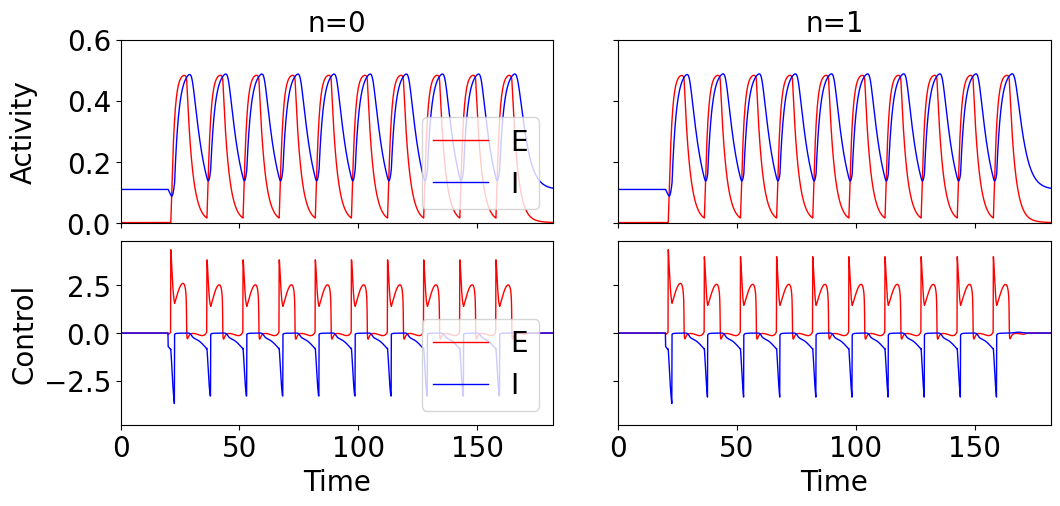

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.045810503506511446
Cost in iteration 20: -0.05160944046142259
Cost in iteration 40: -0.051991190494490344
Final cost : -0.05200372063538756
Compute control for a deterministic system
Cost in iteration 0: -0.05200372063538756
Cost in iteration 20: -0.05201124681194524
Cost in iteration 40: -0.05202372187925354
Final cost : -0.05202994243828496
Compute control for a deterministic system
Cost in iteration 0: -0.05202994243828496
Cost in iteration 20: -0.052038096906157474
Cost in iteration 40: -0.052039945162869625
Final cost : -0.052039983728590804
Compute control for a deterministic system
Cost in iteration 0: -0.052039983728590804
Converged in iteration 2 with cost -0.052039983728590804
Final cost : -0.052039983728590804
Compute control for a deterministic system
Cost in iteration 0: -0.052039983728590804
Converged in iteration 2 with cost -0.052039983728590804
Final cost :

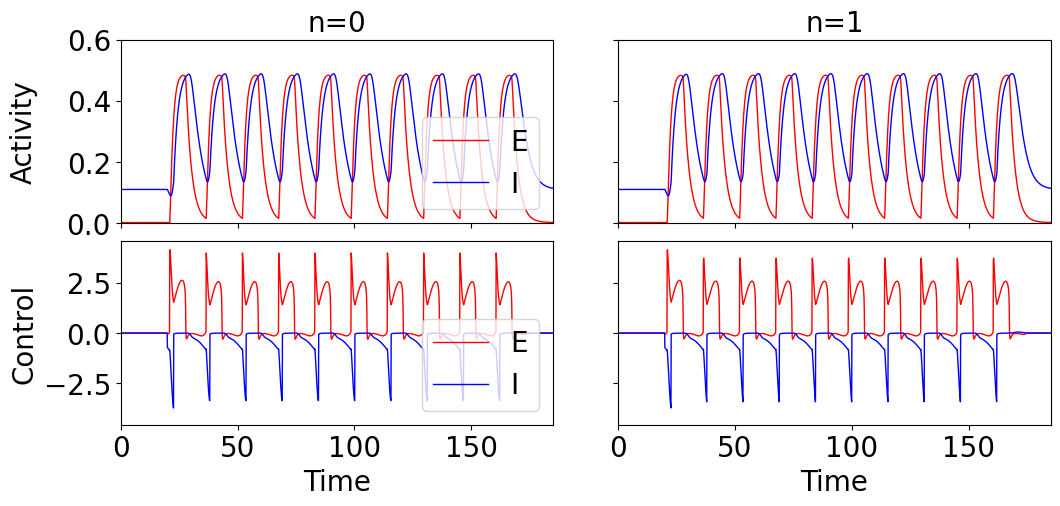

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.04616303256918301
Cost in iteration 20: -0.05208141277392798
Cost in iteration 40: -0.052527496255303806
Final cost : -0.05255111698213284
Compute control for a deterministic system
Cost in iteration 0: -0.05255111698213284
Cost in iteration 20: -0.05255655908042087
Cost in iteration 40: -0.052557216323329894
Final cost : -0.05255757263722759
Compute control for a deterministic system
Cost in iteration 0: -0.05255757263722759
Cost in iteration 20: -0.052592324126877976
Cost in iteration 40: -0.05259268911035741
Final cost : -0.05259273949405627
Compute control for a deterministic system
Cost in iteration 0: -0.05259273949405627
Converged in iteration 14 with cost -0.052592745271867816
Final cost : -0.052592745271867816
Compute control for a deterministic system
Cost in iteration 0: -0.052592745271867816
Converged in iteration 1 with cost -0.052592745271867816
Final cost : -

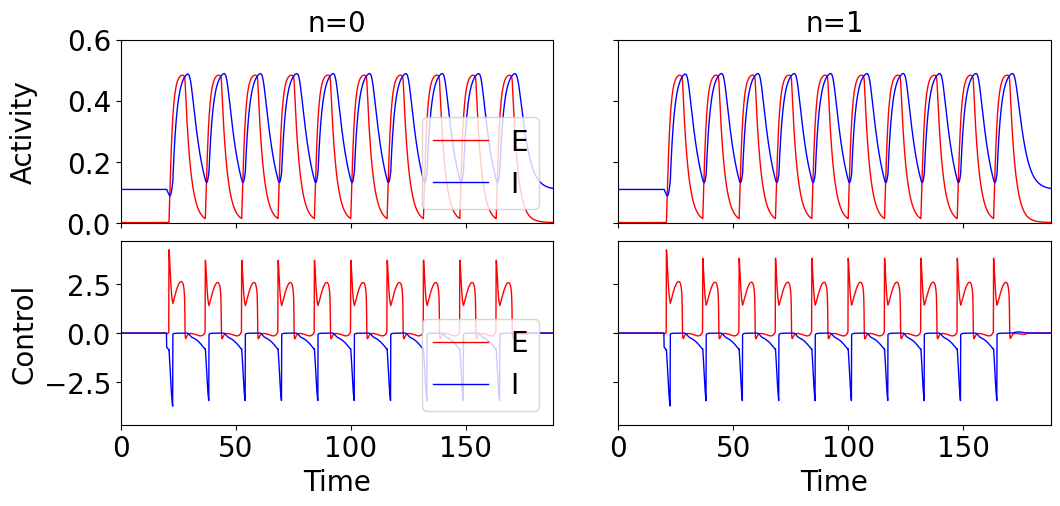

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.049033535410515854
Cost in iteration 20: -0.0556374972379734
Cost in iteration 40: -0.05573342908389193
Final cost : -0.05573754694331773
Compute control for a deterministic system
Cost in iteration 0: -0.05573754694331773
Converged in iteration 19 with cost -0.05574050061392914
Final cost : -0.05574050061392914
Compute control for a deterministic system
Cost in iteration 0: -0.05574050061392914
Converged in iteration 3 with cost -0.05574050850623327
Final cost : -0.05574050850623327
Compute control for a deterministic system
Cost in iteration 0: -0.05574050850623327
Converged in iteration 1 with cost -0.05574050850623327
Final cost : -0.05574050850623327
Compute control for a deterministic system
Cost in iteration 0: -0.05574050850623327
Converged in iteration 1 with cost -0.05574050850623327
Final cost : -0.05574050850623327
------------------------------ period, energy i

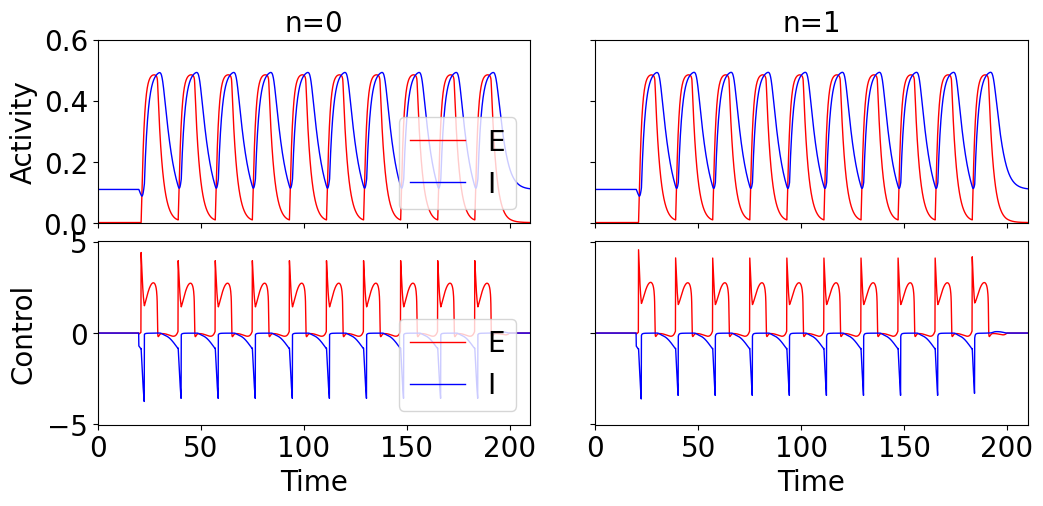

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.04998844926186501
Cost in iteration 20: -0.05741083279704141
Cost in iteration 40: -0.05759985581636204
Final cost : -0.057612149532952225
Compute control for a deterministic system
Cost in iteration 0: -0.057612149532952225
Cost in iteration 20: -0.0576213741459376
Cost in iteration 40: -0.057622441515333495
Final cost : -0.057622562320264026
Compute control for a deterministic system
Cost in iteration 0: -0.057622562320264026
Converged in iteration 6 with cost -0.05762260131602162
Final cost : -0.05762260131602162
Compute control for a deterministic system
Cost in iteration 0: -0.05762260131602162
Converged in iteration 2 with cost -0.05762260131602162
Final cost : -0.05762260131602162
Compute control for a deterministic system
Cost in iteration 0: -0.05762260131602162
Converged in iteration 2 with cost -0.05762260131602162
Final cost : -0.05762260131602162
--------------

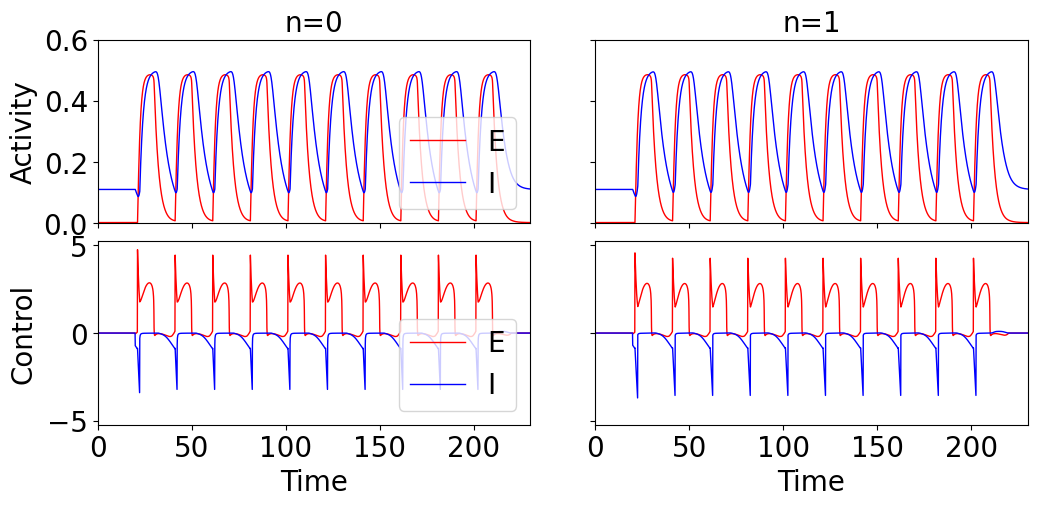

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.050592054474860315
Cost in iteration 20: -0.05920959760469181
Cost in iteration 40: -0.05946242245085539
Final cost : -0.05947431892915966
Compute control for a deterministic system
Cost in iteration 0: -0.05947431892915966
Cost in iteration 20: -0.05948440521354922
Cost in iteration 40: -0.059497992738448004
Final cost : -0.05952371652153261
Compute control for a deterministic system
Cost in iteration 0: -0.05952371652153261
Converged in iteration 13 with cost -0.05952392595868441
Final cost : -0.05952392595868441
Compute control for a deterministic system
Cost in iteration 0: -0.05952392595868441
Converged in iteration 2 with cost -0.05952392595868441
Final cost : -0.05952392595868441
Compute control for a deterministic system
Cost in iteration 0: -0.05952392595868441
Converged in iteration 2 with cost -0.05952392595868441
Final cost : -0.05952392595868441
---------------

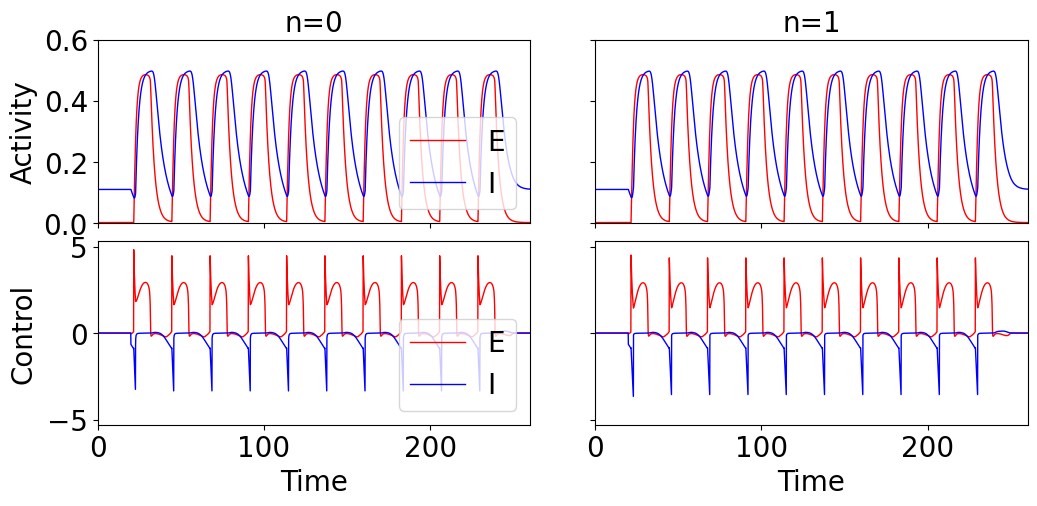

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.0506154660427344
Cost in iteration 20: -0.06032466860693505
Cost in iteration 40: -0.06084736695148261
Final cost : -0.060882545049437714
Compute control for a deterministic system
Cost in iteration 0: -0.060882545049437714
Cost in iteration 20: -0.06089272887116773
Cost in iteration 40: -0.060895833681528594
Final cost : -0.06089638796765808
Compute control for a deterministic system
Cost in iteration 0: -0.06089638796765808
Cost in iteration 20: -0.060896743315080784
Cost in iteration 40: -0.06089688486827023
Final cost : -0.060896958872450196
Compute control for a deterministic system
Cost in iteration 0: -0.060896958872450196
Converged in iteration 14 with cost -0.06089696428593719
Final cost : -0.06089696428593719
Compute control for a deterministic system
Cost in iteration 0: -0.06089696428593719
Converged in iteration 2 with cost -0.06089696428593719
Final cost : -0.

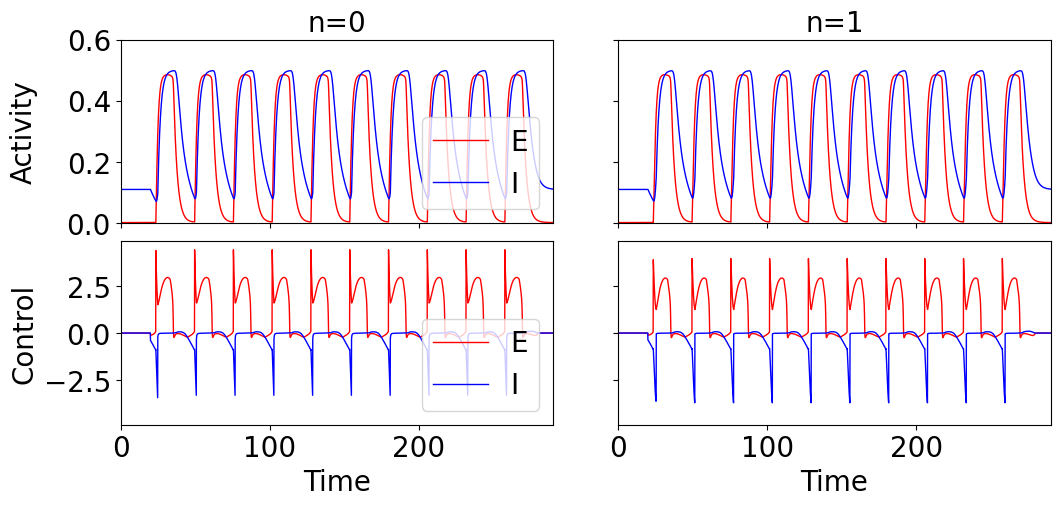

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.05134233637467214
Cost in iteration 20: -0.06155759182475669
Cost in iteration 40: -0.0621755930032824
Final cost : -0.06220971344764393
Compute control for a deterministic system
Cost in iteration 0: -0.06220971344764393
Cost in iteration 20: -0.06223026201359835
Cost in iteration 40: -0.06223330061830719
Final cost : -0.06223356967317005
Compute control for a deterministic system
Cost in iteration 0: -0.06223356967317005
Cost in iteration 20: -0.0622339540494964
Converged in iteration 21 with cost -0.0622339540494964
Final cost : -0.0622339540494964
Compute control for a deterministic system
Cost in iteration 0: -0.0622339540494964
Converged in iteration 2 with cost -0.0622339540494964
Final cost : -0.0622339540494964
Compute control for a deterministic system
Cost in iteration 0: -0.0622339540494964
Converged in iteration 2 with cost -0.0622339540494964
Final cost : -0.0

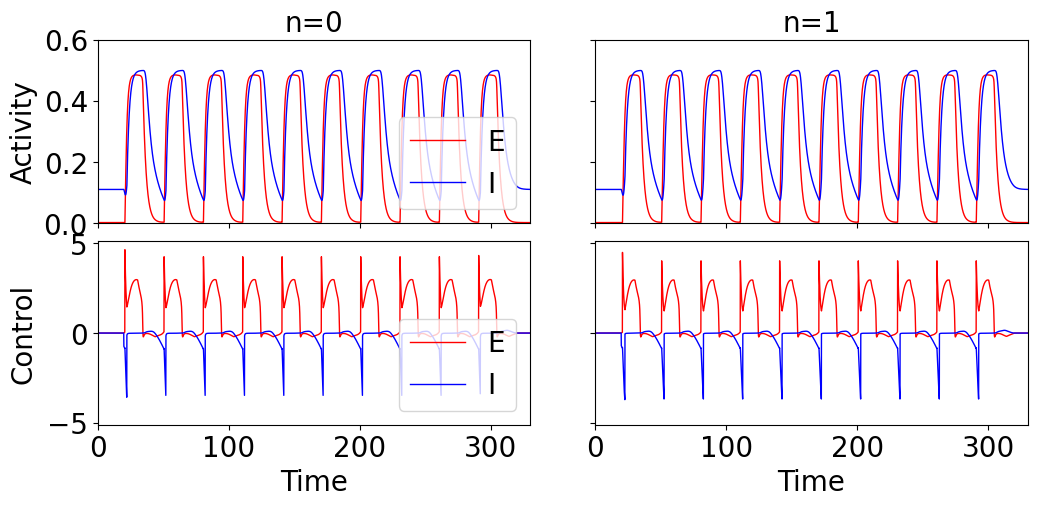

In [13]:
for fi, target_period in enumerate(period_range):

    #if fi not in [2,3,7,11,13,17,19]: continue

    model = WCModel(Cmat=cmat, Dmat=data[p_names[pi]]["delay"]*20.*cmat)
    model.params["exc_ext_baseline"] =  data["D-exp"]["coordinates"][0]
    model.params["inh_ext_baseline"] =  data["D-exp"]["coordinates"][1]
    model.params.K_gl = coupling
    
    int0 = 200
    int1 = int0 + int(data["D-exp"]["dur/per"][1]*target_period/dt)
    model.params.duration = int1 * dt + 10

    zero_input0 = ZeroInput().generate_input(duration=model.params.duration+model.params.dt, dt=model.params.dt)
    zero_input = np.vstack( ([zero_input0]*2) )[np.newaxis,:,:]
    zero_control = np.vstack( ([zero_input]*N))
    model.params["exc_ext"] = zero_control[:,0,:]
    model.params["inh_ext"] = zero_control[:,1,:]

    model.params["exc_init"] = data["D-exp"]["init_state"][0]
    model.params["inh_init"] = data["D-exp"]["init_state"][1]
    model.run()    

    w2 = 0.2 * 1e-3 * 0.1

    model_controlled = oc_wc.OcWc(model, target_period, print_array=pr, cost_interval=(int0,int1), control_interval=(int0, int1), 
                                    cost_matrix=costmat, control_matrix=controlmat, )
    model_controlled.channelwise_optimization = True
    model_controlled.weights["w_p"] = 0.
    model_controlled.weights["w_2"] = w2
    model_controlled.weights["w_f_sync"] = 1.

    model_controlled.maximum_control_strength = maxstr

    if True:
        if type(c0[fi]) != type(None):
            model_controlled.control = c0[fi].copy()
            model_controlled.update_input()

    if False:
        sin_input = zero_control.copy()
        sin_input[0,0,int0:int1] = 1. + np.sin(2. * np.pi * np.arange(0,(int1-int0)*dt, dt)/target_period)
        sin_input[1,0,int0:int1] = sin_input[0,0,int0:int1]
        model_controlled.control = sin_input.copy()
        model_controlled.update_input()

    model_controlled.grad_method = 0
    model_controlled.channelwise_optimization = True

    for l in range(1):
        for k in np.arange(0., 10., 2.):
            model_controlled.zero_step_encountered = False
            model_controlled.step = 10**(k)
            model_controlled.optimize(it)

    for j in range(0):
        for l in range(1):
            for k in np.arange(-10., 10., 2.):
                model_controlled.zero_step_encountered = False
                model_controlled.step = 10**(k)
                model_controlled.optimize(it)

        model_controlled.grad_method = 1

        for l in range(1):
            for k in np.arange(-8., 8., 2.):
                model_controlled.zero_step_encountered = False
                model_controlled.step = 10**(k)
                model_controlled.optimize(10)

    c0[fi] = model_controlled.control.copy()
    s0[fi] = model_controlled.get_xs()

    print("------------------------------ period, energy input = ", target_period, cost_functions.control_strength_cost(c0[fi], weights, dt))
    plot_control1(c0[fi], s0[fi], model_controlled.model.params.duration, dt)

In [66]:
for fi, target_period in enumerate(period_range):

    #if fi not in [1,2, 9, 11, ]: continue

    model = WCModel(Cmat=cmat, Dmat=data[p_names[pi]]["delay"]*20.*cmat)
    model.params["exc_ext_baseline"] =  data["D-exp"]["coordinates"][0]
    model.params["inh_ext_baseline"] =  data["D-exp"]["coordinates"][1]
    model.params.K_gl = coupling

    zero_input0 = ZeroInput().generate_input(duration=model.params.duration+model.params.dt, dt=model.params.dt)
    zero_input = np.vstack( ([zero_input0]*2) )[np.newaxis,:,:]
    zero_control = np.vstack( ([zero_input]*N))
    model.params["exc_ext"] = zero_control[:,0,:]
    model.params["inh_ext"] = zero_control[:,1,:]

    model.params["exc_init"] = data["D-exp"]["init_state"][0]
    model.params["inh_init"] = data["D-exp"]["init_state"][1]

    model.run()
    
    int0 = 200
    int1 = int0 + int(data["D-exp"]["dur/per"][1]*target_period/dt)
    model.params.duration = int1 * dt + 10

    w2 = 1e-3

    model_controlled = oc_wc.OcWc(model, target_period, print_array=pr, cost_interval=(int0,int1), control_interval=(int0, int1), 
                                    cost_matrix=costmat, control_matrix=controlmat, )
    model_controlled.channelwise_optimization = True
    model_controlled.weights["w_p"] = 0.
    model_controlled.weights["w_2"] = w2
    model_controlled.weights["w_f_sync"] = 1.

    model_controlled.maximum_control_strength = maxstr

    if True:
        if type(c1[fi]) != type(None):
            model_controlled.control = c1[fi].copy()
            model_controlled.update_input()

    model_controlled.grad_method = 0
    model_controlled.channelwise_optimization = True

    for l in range(1):
        for k in np.arange(0., 10., 2.):
            model_controlled.zero_step_encountered = False
            model_controlled.step = 10**(k)
            model_controlled.optimize(it)

    for j in range(1):
        for l in range(1):
            for k in np.arange(-10., 10., 2.):
                model_controlled.zero_step_encountered = False
                model_controlled.step = 10**(k)
                model_controlled.optimize(it)

        model_controlled.grad_method = 1

        for l in range(1):
            for k in np.arange(-8., 8., 2.):
                model_controlled.zero_step_encountered = False
                model_controlled.step = 10**(k)
                model_controlled.optimize(10)

    c1[fi] = model_controlled.control.copy()
    s1[fi] = model_controlled.get_xs()

    print("------------------------------ period, energy input = ", target_period, cost_functions.control_strength_cost(c1[fi], weights, dt))
    #plot_control1(c1[fi], s1[fi], model_controlled.model.params.duration, dt)

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -7.667118253642644e-35
Converged in iteration 1 with cost -7.667118253642644e-35
Final cost : -7.667118253642644e-35
Compute control for a deterministic system
Cost in iteration 0: -7.667118253642644e-35
Converged in iteration 1 with cost -7.667118253642644e-35
Final cost : -7.667118253642644e-35
Compute control for a deterministic system
Cost in iteration 0: -7.667118253642644e-35
Converged in iteration 1 with cost -7.667118253642644e-35
Final cost : -7.667118253642644e-35
Compute control for a deterministic system
Cost in iteration 0: -7.667118253642644e-35
Converged in iteration 1 with cost -7.667118253642644e-35
Final cost : -7.667118253642644e-35
Compute control for a deterministic system
Cost in iteration 0: -7.667118253642644e-35
Converged in iteration 1 with cost -7.667118253642644e-35
Final cost : -7.667118253642644e-35
Compute control for a deterministic system
Cost 

In [ ]:
for fi, target_period in enumerate(period_range):

    #if fi not in [11]: continue

    model = WCModel(Cmat=cmat, Dmat=data[p_names[pi]]["delay"]*20.*cmat)
    model.params["exc_ext_baseline"] =  data["D-exp"]["coordinates"][0]
    model.params["inh_ext_baseline"] =  data["D-exp"]["coordinates"][1]
    model.params.K_gl = coupling

    zero_input0 = ZeroInput().generate_input(duration=model.params.duration+model.params.dt, dt=model.params.dt)
    zero_input = np.vstack( ([zero_input0]*2) )[np.newaxis,:,:]
    zero_control = np.vstack( ([zero_input]*N))
    model.params["exc_ext"] = zero_control[:,0,:]
    model.params["inh_ext"] = zero_control[:,1,:]

    model.params["exc_init"] = data["D-exp"]["init_state"][0]
    model.params["inh_init"] = data["D-exp"]["init_state"][1]

    model.run()
    
    int0 = 200
    int1 = int0 + int(data["D-exp"]["dur/per"][1]*target_period/dt)
    model.params.duration = int1 * dt + 10

    w2 = 0.2 * 0.2 * 1e-3

    model_controlled = oc_wc.OcWc(model, target_period, print_array=pr, cost_interval=(int0,int1), control_interval=(int0, int1), 
                                    cost_matrix=costmat, control_matrix=controlmat, )
    model_controlled.channelwise_optimization = True
    model_controlled.weights["w_p"] = 0.
    model_controlled.weights["w_2"] = w2
    model_controlled.weights["w_f_sync"] = 1.

    model_controlled.maximum_control_strength = maxstr

    if True:
        if type(c2[fi]) != type(None):
            model_controlled.control = c2[fi].copy()
            model_controlled.update_input()

    model_controlled.grad_method = 0
    model_controlled.channelwise_optimization = True

    for l in range(1):
        for k in np.arange(0., 10., 2.):
            model_controlled.zero_step_encountered = False
            model_controlled.step = 10**(k)
            model_controlled.optimize(it)

    for j in range(1):
        for l in range(1):
            for k in np.arange(-10., 10., 2.):
                model_controlled.zero_step_encountered = False
                model_controlled.step = 10**(k)
                model_controlled.optimize(it)

        model_controlled.grad_method = 1

        for l in range(1):
            for k in np.arange(-8., 8., 2.):
                model_controlled.zero_step_encountered = False
                model_controlled.step = 10**(k)
                model_controlled.optimize(10)

    c2[fi] = model_controlled.control.copy()
    s2[fi] = model_controlled.get_xs()

    print("------------------------------ period, energy input = ", target_period, cost_functions.control_strength_cost(c2[fi], weights, dt))
    #plot_control1(c2[fi], s2[fi], model_controlled.model.params.duration, dt)

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.04118457011491402
Converged in iteration 12 with cost -0.04118457128020554
Final cost : -0.04118457128020554
Compute control for a deterministic system
Cost in iteration 0: -0.04118457128020554
Converged in iteration 4 with cost -0.04118457137216362
Final cost : -0.04118457137216362
Compute control for a deterministic system
Cost in iteration 0: -0.04118457137216362
Converged in iteration 2 with cost -0.04118457137216362
Final cost : -0.04118457137216362
Compute control for a deterministic system
Cost in iteration 0: -0.04118457137216362
Converged in iteration 2 with cost -0.04118457137216362
Final cost : -0.04118457137216362
Compute control for a deterministic system
Cost in iteration 0: -0.04118457137216362
Converged in iteration 2 with cost -0.04118457137216362
Final cost : -0.04118457137216362
Compute control for a deterministic system
Cost in iteration 0: -0.0411845713

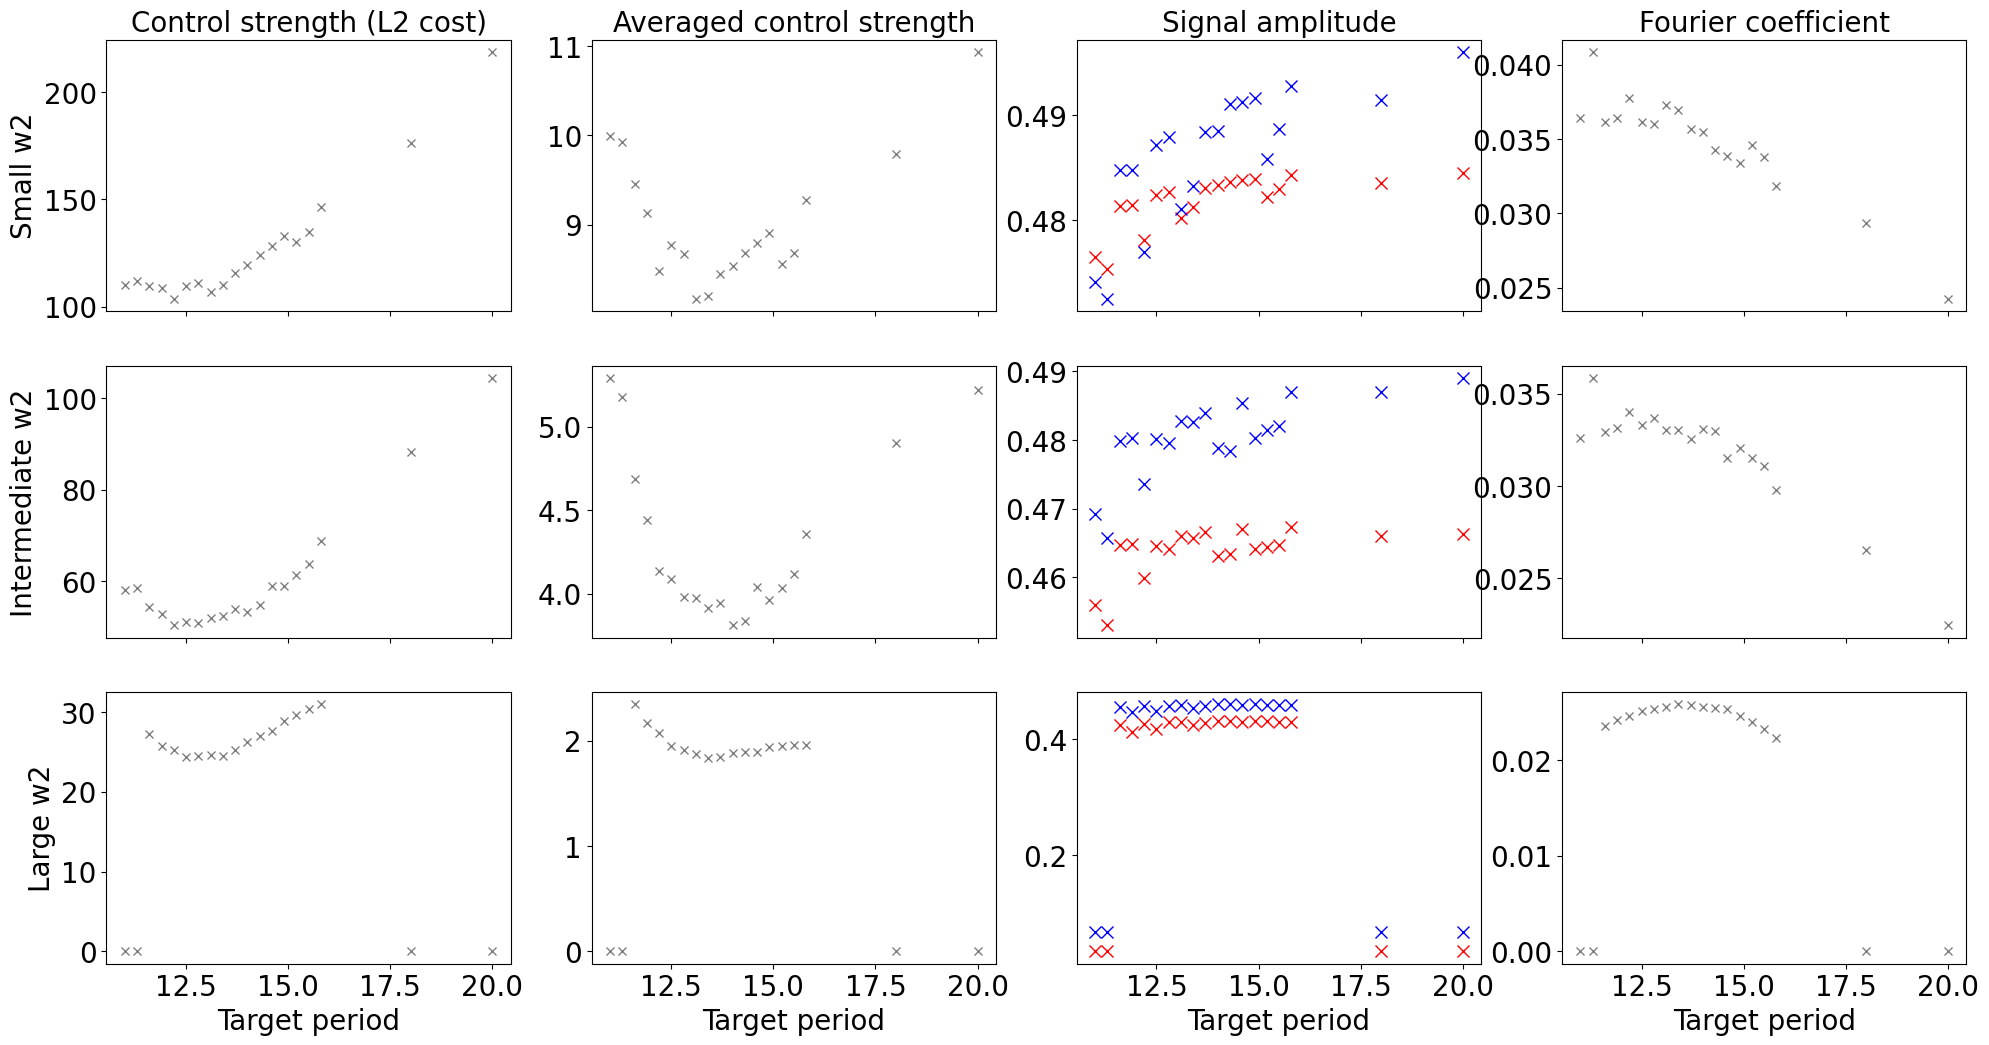

In [64]:
fig, ax = plt.subplots(3,4, figsize=(24,12), sharex=True)

for fi, target_period in enumerate(period_range):

    int0 = 200
    int1 = int0 + int(data["D-osc"]["dur/per"][1]*target_period/dt)

    col = "gray"
    ms = 8
    
    control_strength = cost_functions.control_strength_cost(c2[fi], weights, dt)
    av_control_strength = control_strength / target_period
    osc_amp = [np.amax(s2[fi][:,0,:]), np.amax(s2[fi][:,1,:])]
    fourier_cost = - sum(cost_functions.fourier_cost_sync(s2[fi], dt, target_period, costmat, [int0,int1]))

    ax[0,0].plot(target_period, control_strength, marker="x",color=col)
    ax[0,1].plot(target_period, av_control_strength, marker="x",color=col)
    ax[0,2].plot(target_period, osc_amp[0], marker="x",color="red", markersize=ms)
    ax[0,2].plot(target_period, osc_amp[1], marker="x",color="blue", markersize=ms)
    ax[0,3].plot(target_period, fourier_cost, marker="x",color=col)

    control_strength = cost_functions.control_strength_cost(c0[fi], weights, dt)
    av_control_strength = control_strength / target_period
    osc_amp = [np.amax(s0[fi][:,0,:]), np.amax(s0[fi][:,1,:])]
    fourier_cost = - sum(cost_functions.fourier_cost_sync(s0[fi], dt, target_period, costmat, [int0,int1]))

    ax[1,0].plot(target_period, control_strength, marker="x",color=col)
    ax[1,1].plot(target_period, av_control_strength, marker="x",color=col)
    ax[1,2].plot(target_period, osc_amp[0], marker="x",color="red", markersize=ms)
    ax[1,2].plot(target_period, osc_amp[1], marker="x",color="blue", markersize=ms)
    ax[1,3].plot(target_period, fourier_cost, marker="x",color=col)

    control_strength = cost_functions.control_strength_cost(c1[fi], weights, dt)
    av_control_strength = control_strength / target_period
    osc_amp = [np.amax(s1[fi][:,0,:]), np.amax(s1[fi][:,1,:])]
    fourier_cost = - sum(cost_functions.fourier_cost_sync(s1[fi], dt, target_period, costmat, [int0,int1]))

    ax[2,0].plot(target_period, control_strength, marker="x",color=col)
    ax[2,1].plot(target_period, av_control_strength, marker="x",color=col)
    ax[2,2].plot(target_period, osc_amp[0], marker="x",color="red", markersize=ms)
    ax[2,2].plot(target_period, osc_amp[1], marker="x",color="blue", markersize=ms)
    ax[2,3].plot(target_period, fourier_cost, marker="x",color=col)

ax[0,0].set_title("Control strength (L2 cost)")
ax[0,1].set_title("Averaged control strength")
ax[0,2].set_title("Signal amplitude")
ax[0,3].set_title("Fourier coefficient")

ax[0,0].set_ylabel("Small w2")
ax[1,0].set_ylabel("Intermediate w2")
ax[2,0].set_ylabel("Large w2")

ax[-1,0].set_xlabel("Target period")
ax[-1,1].set_xlabel("Target period")
ax[-1,2].set_xlabel("Target period")
ax[-1,3].set_xlabel("Target period")

plt.show()
fig.tight_layout()

fig.savefig(os.path.join(dir, "freq_range.png"))

In [ ]:
with open(os.path.join(pickledir, '2n_wc_static_short.pickle'), 'wb') as f:
    pickle.dump(data, f)

In [4]:
with open(os.path.join(pickledir, '2n_wc_static_short.pickle'), 'rb') as f:
    res_read = pickle.load(f)
    print(res_read.keys() )

data = res_read.copy()

dict_keys(['D-exp', 'D-osc', 'U-exp', 'U-osc', 'Bi-exp', 'Bi-osc'])
